In [1]:
from xgboost import XGBRegressor
import os
os.environ['NUMEXPR_MAX_THREADS'] = '10' #<---- set your max threads to your computer's specifications
os.environ['NUMEXPR_NUM_THREADS'] = '10'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from joblib import dump, load

df_train = pd.read_feather('df_neut_training_compressed_nomi80.feather')
features = [c for c in df_train if c.startswith("feature")]
df_train['era'] = df_train.loc[:, 'era'].str[3:].astype(int)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 315 entries, id to neutralized_target
dtypes: float32(310), float64(2), int32(1), object(2)
memory usage: 610.6+ MB


In [4]:
model = XGBRegressor(max_depth = 5, learning_rate = 0.01, n_estimators = 2000, n_jobs = -1, colsample_bytree = 0.1)#, tree_method = 'gpu_hist')

y = df_train.neutralized_target.values

features = [c for c in df_train if c.startswith("feature")]

X = df_train[features].values

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
df_val = pd.read_feather('validation_compressed_nomi.feather')
df_val['era'] = df_val.loc[:, 'era'].str[3:].astype(int)
preds = model.predict(df_val[features].values)
df_val['preds'] = preds

C:\Users\jtaylo98\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
performance over time


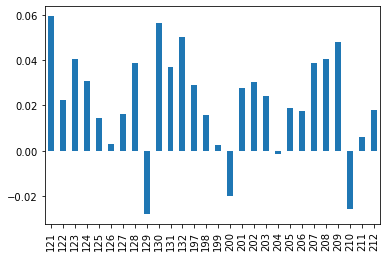

Maximum Drawdown (Minimum Score)
-0.027877526900198582
Average Correlation
0.021893915951238886
Median Correlation
0.023402524865575224
Variance
0.0005008466464270914
Std. Dev.
0.022379603357233376
Autocorrelation
-0.005925907165487958
Sharpe
3.388922868638041
Smart Sharpe
3.308894104633665
Numerai Sharpe
1.7767784879983728
Skewness
-0.5496670809218124
Excess Kurtosis
-0.15487777242749834
Standard Error of the Mean
0.00430695667421858
Annualized Sharpe
1.7767784879983728
Adjusted Sharpe
2.2249130362976763
Value at Risk (VaR) with 10% probability of occurring
-0.021737966949264467
Smart Sortino Ratio
0.9415172952755326
Sortino Ratio
0.9469127942262014


In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(12))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]


era_col = df_val.era
new_df = df_val.copy()
new_df['era'] = era_col
new_df["pred"] = df_val.preds
era_scores = pd.Series(index=new_df['era'].unique())
print("getting per era scores")
for era in new_df['era'].unique():
    era_df = new_df[new_df['era'] == era]
    era_scores[era] = spearmanr(era_df['pred'], era_df['target'])
era_scores.sort_values(inplace=True)
era_scores.sort_index(inplace=True)
era_scores.plot(kind="bar")
print("performance over time")
plt.show()

print("Maximum Drawdown (Minimum Score)")
print(np.min(era_scores))
print("Average Correlation")
print(np.mean(era_scores))
print("Median Correlation")
print(np.median(era_scores))
print("Variance")
print(np.var(era_scores))
print("Std. Dev.")
print(np.std(era_scores))
print("Autocorrelation")
print(ar1(era_scores))
print("Sharpe")
print(np.mean(era_scores)/np.std(era_scores) * np.sqrt(12))
print("Smart Sharpe")
print(smart_sharpe(era_scores))
print("Numerai Sharpe")
print(numerai_sharpe(era_scores))
import scipy 
from scipy.stats import skew, kurtosis, sem, gmean

print("Skewness")
print(skew(era_scores))
print("Excess Kurtosis")
print(kurtosis(era_scores))
print("Standard Error of the Mean")
print(sem(era_scores))


def annual_sharpe(x):
    return ((np.mean(x) -0.010415154) /np.std(x)) * np.sqrt(12)

print("Annualized Sharpe")
print(annual_sharpe(era_scores))
def adj_sharpe(x):
    return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - ((kurtosis(x) - 3) / 24) * (annual_sharpe(x) ** 2))
print("Adjusted Sharpe")
print(adj_sharpe(era_scores))

def VaR(x):
    return -np.mean(x) - np.sqrt(np.var(x)) * np.percentile(x, 10)
print("Value at Risk (VaR) with 10% probability of occurring")
print(VaR(era_scores))
def smart_sortino_ratio(x, target=0.010415154):
    xt = x - target
    return np.mean(xt)/(((np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5)*autocorr_penalty(x))
print("Smart Sortino Ratio")
print(smart_sortino_ratio(era_scores))
def sortino_ratio(x, target=0.010415154):
    xt = x - target
    return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5
print("Sortino Ratio")
print(sortino_ratio(era_scores))

In [17]:
df_val = pd.read_feather('validation_compressed_nomi.feather')
df_val['era'] = df_val.loc[:, 'era'].str[3:].astype(int)
ex_preds = pd.read_csv('example_predictions.csv')
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data['preds'] = ex_preds.prediction
df_val = tournament_data[tournament_data.data_type == "validation"].copy()

C:\Users\jtaylo98\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
performance over time


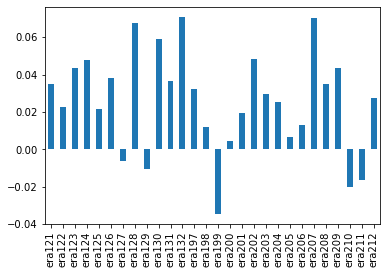

Maximum Drawdown (Minimum Score)
-0.034826069947569156
Average Correlation
0.02577288711854387
Median Correlation
0.02849796114018107
Variance
0.0007183244535607144
Std. Dev.
0.026801575579818333
Autocorrelation
0.011327574761735622
Sharpe
3.331143709377253
Smart Sharpe
3.235581264983064
Numerai Sharpe
1.9849858431779186
Skewness
-0.3148614463735574
Excess Kurtosis
-0.41577520831091475
Standard Error of the Mean
0.005157965625238071
Annualized Sharpe
1.9849858431779186
Adjusted Sharpe
2.8913592310251746
Value at Risk (VaR) with 10% probability of occurring
-0.02544198585836388
Smart Sortino Ratio
1.180835294469448
Sortino Ratio
1.193804602474968


In [22]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(12))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]


era_col = df_val.era
new_df = df_val.copy()
new_df['era'] = era_col
new_df["pred"] = df_val.preds
era_scores = pd.Series(index=new_df['era'].unique())
print("getting per era scores")
for era in new_df['era'].unique():
    era_df = new_df[new_df['era'] == era]
    era_scores[era] = spearmanr(era_df['pred'], era_df['target'])
era_scores.sort_values(inplace=True)
era_scores.sort_index(inplace=True)
era_scores.plot(kind="bar")
print("performance over time")
plt.show()

print("Maximum Drawdown (Minimum Score)")
print(np.min(era_scores))
print("Average Correlation")
print(np.mean(era_scores))
print("Median Correlation")
print(np.median(era_scores))
print("Variance")
print(np.var(era_scores))
print("Std. Dev.")
print(np.std(era_scores))
print("Autocorrelation")
print(ar1(era_scores))
print("Sharpe")
print(np.mean(era_scores)/np.std(era_scores) * np.sqrt(12))
print("Smart Sharpe")
print(smart_sharpe(era_scores))
print("Numerai Sharpe")
print(numerai_sharpe(era_scores))
import scipy 
from scipy.stats import skew, kurtosis, sem, gmean

print("Skewness")
print(skew(era_scores))
print("Excess Kurtosis")
print(kurtosis(era_scores))
print("Standard Error of the Mean")
print(sem(era_scores))


def annual_sharpe(x):
    return ((np.mean(x) -0.010415154) /np.std(x)) * np.sqrt(12)

print("Annualized Sharpe")
print(annual_sharpe(era_scores))
def adj_sharpe(x):
    return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - ((kurtosis(x) - 3) / 24) * (annual_sharpe(x) ** 2))
print("Adjusted Sharpe")
print(adj_sharpe(era_scores))

def VaR(x):
    return -np.mean(x) - np.sqrt(np.var(x)) * np.percentile(x, 10)
print("Value at Risk (VaR) with 10% probability of occurring")
print(VaR(era_scores))
def smart_sortino_ratio(x, target=0.010415154):
    xt = x - target
    return np.mean(xt)/(((np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5)*autocorr_penalty(x))
print("Smart Sortino Ratio")
print(smart_sortino_ratio(era_scores))
def sortino_ratio(x, target=0.010415154):
    xt = x - target
    return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5
print("Sortino Ratio")
print(sortino_ratio(era_scores))